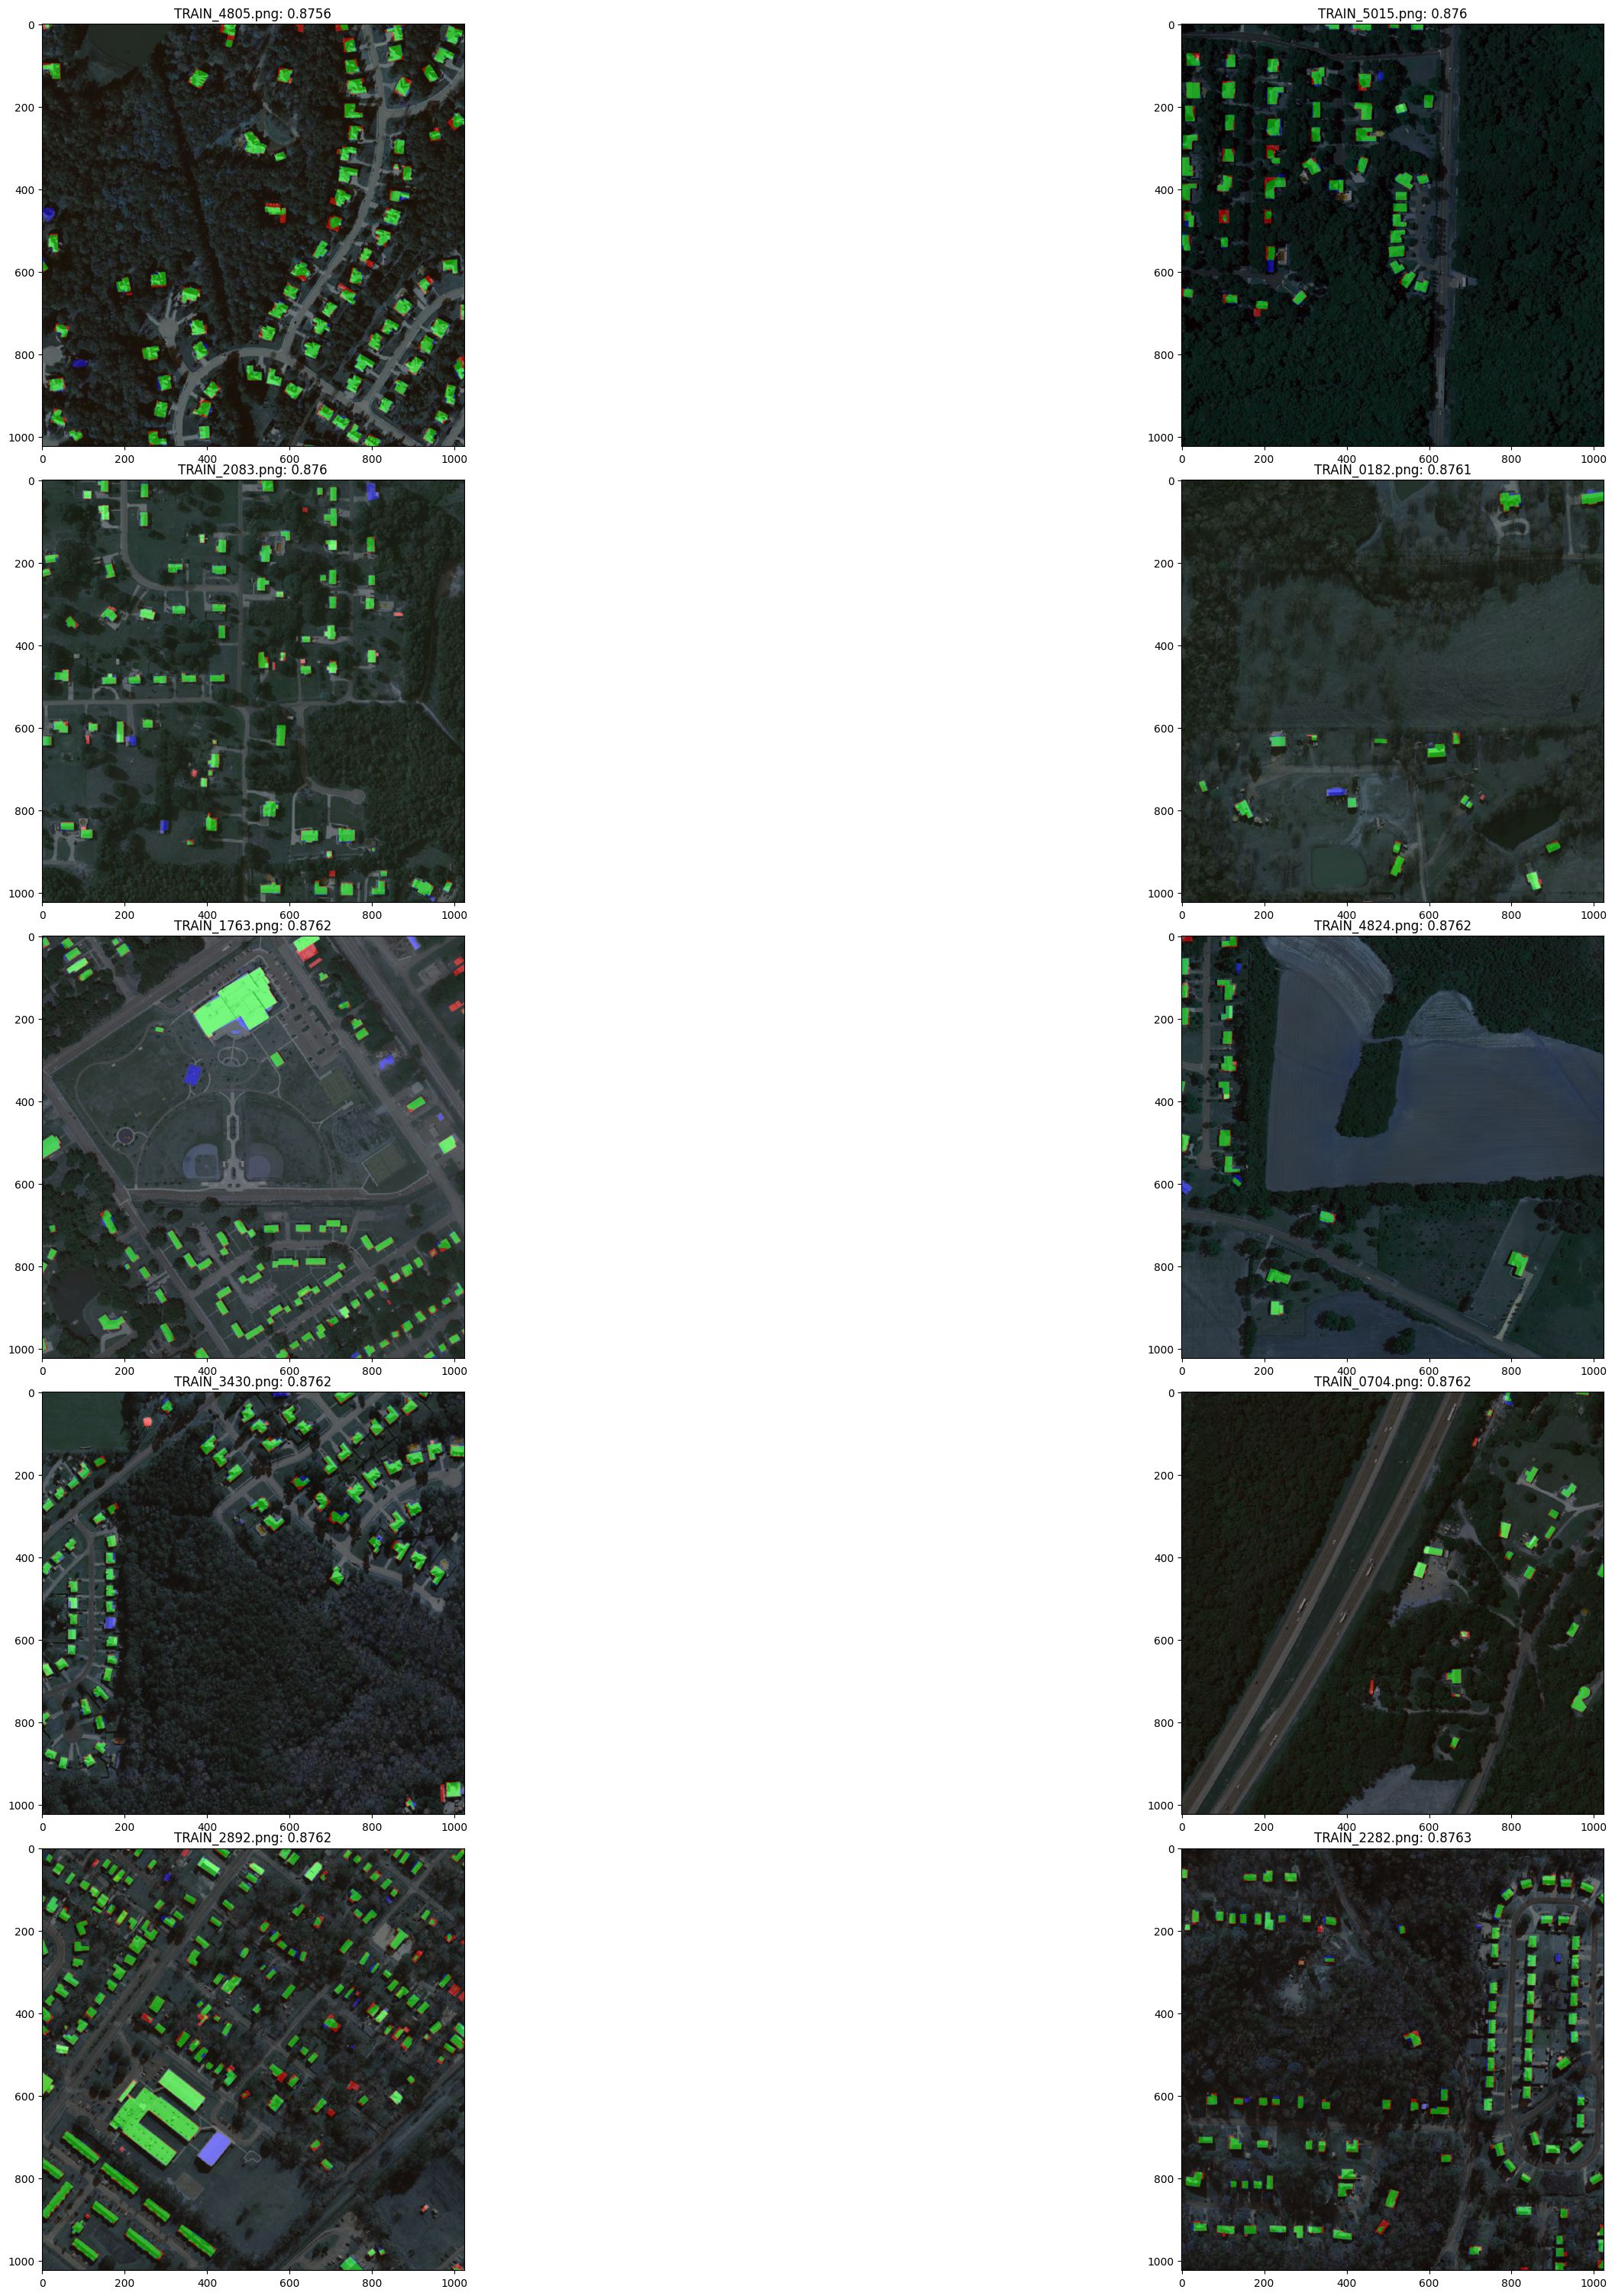

interactive(children=(IntSlider(value=70, description='idx', max=141), Output()), _dom_classes=('widget-intera…

In [8]:
import os, cv2
import mmcv
import torch
from tqdm import tqdm
from mmseg.apis import init_model, inference_model
from ipywidgets import widgets, interact

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

# pred, gt = 없음
# pred O, gt X = [0, 0, 255] 파란색
# pred X, gt O = [255, 0, 0] 빨간색
# pred O, gt O = [0, 255, 0] 녹색

palette = np.array([[0, 0, 0], [0, 0, 255], [255, 0, 0], [0, 255, 0]])
check_num = 10
dice_score_list = []

def dice_score(prediction: np.array, ground_truth: np.array, smooth=1e-7):
    intersection = np.sum(prediction * ground_truth)
    return (2.0 * intersection + smooth) / (np.sum(prediction) + np.sum(ground_truth) + smooth)

def calculate_dice(pred, gt):
    if np.sum(gt) > 0 or np.sum(pred) > 0:
        return dice_score(pred, gt)
    else:
        return None  # No valid masks found, return None

def visualize(idx):
    global dice_score_list, check_num
    fig, ax = plt.subplots(check_num//2, 2, figsize=(30, 30))
    fig.tight_layout()
    plt.clf()
    for i in range(check_num):
        table = dice_score_list[idx*check_num + i]
        img = cv2.imread(table[0])
        mask = table[1]
        mask = palette[mask]
        plt.subplot(check_num // 2, 2, i+1)
        plt.title(os.path.basename(table[0]) + ": " + str(round(table[2], 4)))
        plt.imshow(img)
        plt.imshow(mask, alpha=0.5)
    plt.show()

def main():
    img_dir = "/home/jovyan/work/datasets/satellite/images/validation"
    anno_dir = "/home/jovyan/work/datasets/satellite/annotations/validation"
    file_name = "deeplabv3p_re"
    config_path = os.path.join('/home/jovyan/work/work_space/uijin/submit/mmseg/configs', file_name+".py")  
    ckpt_path = os.path.join('/home/jovyan/work/work_space/uijin/submit/mmseg/ckpts', file_name+".pth")
    device = "cuda:1"
        
    model = init_model(config_path, ckpt_path, device)
    img_list = [f for f in os.listdir(img_dir) if os.path.splitext(f)[1] == ".png"]
    # img_list = ["TRAIN_" + f + ".png" for f in ("0948", "2108", "4873", "1092", "5251", "2956", "1251", "4283", "1206", "1848")]
    global dice_score_list
    i = 10
    with torch.no_grad():
        model.eval()
        ratio = 2
        for img_id in tqdm(img_list):
            img_path = os.path.join(img_dir, img_id)
            anno_path = os.path.join(anno_dir, img_id)
            img = cv2.imread(img_path, 1)
            anno = cv2.imread(anno_path, 0)
            resized_img = cv2.resize(img, 
                                     dsize=(int(img.shape[0]*ratio), 
                                            int(img.shape[1]*ratio)))
            resized_mask = inference_model(model, resized_img)
            resized_mask = resized_mask.pred_sem_seg.data
            resized_mask = torch.squeeze(resized_mask).cpu().numpy()
            mask = cv2.resize(resized_mask.astype("float32"), 
                              dsize=(img.shape[0], img.shape[1])).astype("int32")
            score = calculate_dice(mask, anno)
            mask = 2*anno + mask
            dice_score_list.append((img_path, mask, score))
            # i -= 1
            # if i == 0:
            #     break
    dice_score_list.sort(key = lambda x:x[2])
    
    start = 0
    end = len(img_list) // check_num - 1 
    interact(visualize, idx=(start, end))
if __name__ == "__main__":
    main()